In [252]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
from wordcloud import WordCloud, STOPWORDS 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from sklearn.model_selection import train_test_split

## Make dataframes

In [253]:
def read_tsv(filepath):
    """Reads in a tsv file

    Args:
        filepath (string): filepath and file name of the 
            tsv file to be read into as a pandas dataframe
    Returns:
        Pandas DataFrame
    """    
    return pd.read_csv(filepath, sep = "\t")

In [312]:
def make_q_and_a_col(df):
    """
    Makes a column that concatenates the strings
    from the question and answer columns

    Args:
        df (Pandas DataFrame): 
    Returns:
        Pandas DataFrame with an additional column
    """    
    df['question_and_answer'] = df["question"] + ' ' + df['answer']
    return df

#TODO: make another condition using "view assummptions" 
def make_clue_difficulty_col(df):
    conditions = [((df['value']<=600) & (df['daily_double']=='no')), #easy
                ((df['daily_double']=='no') & ((df['value']==800) | (df['value']==1200))), #average
                ((df['daily_double']== 'yes') & (df['round'] == 1)), #average
                ((df['daily_double']=='no') & ((df['value']==1000) | (df['value']>=1600))), #hard
                ((df['daily_double']== 'yes') & (df['round'] == 2)), #hard
                (df['round'] == 3)] # final jeopardy, hard 


    difficulties = ['easy', 'average', 'average', 'hard', 'hard', 'hard']

    df['clue_difficulty'] = np.select(conditions, difficulties)
    return df

#TODO: write docstring
def update_df_columns(df):
    """[summary]

    Args:
        df ([type]): [description]

    Returns:
        [type]: [description]
    """    
    df_new = make_q_and_a_col(df)
    df_new = make_clue_difficulty_col(df_new)
    return df_new

In [344]:
jeopardy = read_tsv('../data/master_season1-35.tsv')
jeopardy_df = update_df_columns(jeopardy)
regular_episodes = jeopardy_df[jeopardy_df['notes']=='-']
special_tournaments = jeopardy_df.drop(regular_episodes.index)
regular_episodes_sub = regular_episodes.sample(frac = 0.1, axis = 0, random_state = 123)
regular_episodes_sub.head()


,round,value,daily_double,category,comments,answer,question,air_date,notes,question_and_answer,clue_difficulty
120126,2,800,no,WHAT'S WRONG WITH YOU?,-,Underactivity of this butterfly-shaped gland s...,Thyroid gland,2001-02-23,-,Thyroid gland Underactivity of this butterfly-...,average
151920,2,2000,no,GEOMETRY,-,(Cheryl of the Clue Crew in front of a blackbo...,eccentric,2003-10-03,-,eccentric (Cheryl of the Clue Crew in front of...,hard
149746,1,400,no,BIBLE PEOPLE MAGAZINE,(Alex: That sounds like fun!),Star Tracks says that scholars believe these s...,Magi/three wise men,2003-06-24,-,Magi/three wise men Star Tracks says that scho...,easy
146280,1,800,no,ODE TO ENGLAND,-,Headquarters was needed for Peel's new police ...,Scotland Yard,2003-04-01,-,Scotland Yard Headquarters was needed for Peel...,average
151002,2,2000,no,"\""C"" IN SCIENCE",-,"In order to duplicate itself in cell division,...",chromosomes,2003-09-10,-,chromosomes In order to duplicate itself in ce...,hard


In [284]:
def lowercase(df, cols):
    """
    turns the column (col) into one string, 
    whose letters are all lowercase
    to be able to make a wordcloud

    Args:
        df (Pandas dataFrame): The dataframe in use
        col (str): the column name to turn into a string

    Returns:
        a string of lowercase letters 
    """   
    for col in cols: 
        df[col] = df[col].str.lower()
    return df

# lowercase(regular_episodes_sub,['question_and_answer', 'category'])


In [319]:
def tokenize(df, cols):
    for col in cols:
        df[col] = df[col].apply(word_tokenize)
    return df


In [321]:
remove_words = {'man', 'woman', 'person', 'he', 'she', 'they', 'people'}
stopwords_set = (set(stopwords.words('english'))).union(remove_words)
# stopwords_set

In [ ]:
import re

def remove_punc(df, cols):
    """[summary]

    Args:
        df ([type]): [description]
        cols (list of str): list of columns to be cleaned, as strings

    Returns:
        Pandas DataFrame: with removed punctuation
    """
    for col in cols:
        p = re.compile(r'[^\w\s]+')
        df[col] = [p.sub('', x) for x in df[col].tolist()]
    return df



In [350]:
def make_stopwords(col):

    if col == 'notes':
        remove_words = {'final', 'quarterfinal', 'game', 'jeopardy!', 'semifinal', 'round', 'tournament', 'week', 'reunion', 'ultimate'}
        stopwords_set = (set(stopwords.words('english'))).union(remove_words)
    else:
        remove_words = {'man', 'men', 'woman', 'person', 'he', 'she', 'they', 'people', 'with'}
        stopwords_set = (set(stopwords.words('english'))).union(remove_words)
    return list(stopwords_set)

#TODO: clean up this function
def remove_stopwords(df, col):
    """[summary]
    Args:
        df ([type]): [description]
        col ([type]): [description]
    Returns:
        [type]: [description]
    """
    
    df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_set)]))
    return df


# remove_stopwords(regular_episodes_sub, 'question')

## Cleaning function without stemming or lemmatizing (its tokenized)

In [234]:
def clean_text(df, col):
    '''
    using a pre-made function 
    returns a list of the tokenized and stripped of stopwords 
    '''
    text = ' '.join(df[col])
    tokens = word_tokenize(text)
    # converts the tokens to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    words = [word for word in stripped if word.isalnum()]
    
    # filter out stop words
    if col == 'notes':
        #TODO: add another set of stopwords for the notes
        remove_words = {'final', 'quarterfinal', 'game', 'jeopardy!', 'semifinal', 'round', 'tournament', 'week', 'reunion', 'ultimate', 'night', 'jeopardy', 'night', 'games'}
        stopwords_set = (set(stopwords.words('english'))).union(remove_words)
    else:
        stopwords_set = set(stopwords.words('english'))
    words = [w for w in words if not w in stopwords_set]
    return words


## Make wordcloud from cleaning function without stemming and lemamtizing

In [235]:
import matplotlib.pyplot as plt

def make_word_cloud(df, col, color, save = False):

    #generate word list
    word_lst = clean_columns(df, col)
    words = ' '.join(word_lst)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color =None, mode = 'RGBA', 
                colormap = color,
                collocations=False,
                min_font_size = 10).generate(words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None, dpi = 140) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    if save:
        plt.savefig(f'../images/eda_images/{col}_wordcloud.png')
    else:
        plt.show()

In [136]:
# list(regular_episodes['question_difficulty'])

### get wordcount according to question difficulty

In [139]:
maxes

,answer word count,question word count
question difficulty,,
average,52,16
easy,52,18
hard,52,25


In [118]:
len(regular_episodes['answer'][5].split())
#should be ok

9

In [236]:
def get_wrd_cts(df):
    """[summary]

    Args:
        df (Pandas DataFrame): must have the columns "clue_difficulty", "answer", "question"
    """    
    total_wrds_questions = [len(x.split()) for x in df['question'].tolist()]
    total_wrds_answers = [len(x.split()) for x in df['answer'].tolist()]

    data = {'Clue Difficulty': list(df['clue_difficulty']), 
        'Answer Word Count': total_wrds_answers, 
        'Question Word Count': total_wrds_questions}

    df = pd.DataFrame(data, columns = ['Clue Difficulty', 'Answer Word Count', 'Question Word Count'])
    return df

In [249]:
def graph_wrd_cts(df, col, color):
    """
    makes a bar graph of the average word counts

    Args:
        df (Pandas DataFrame): must be a dataframe with wordcounts
            can be made from get_wrd_cts
    """    
    fig, ax = plt.subplots(1, 1, dpi = 150)

    rects1 = ax.bar(df.index, df[col], color = color)
    ax.set_title(f'{col} vs. Clue Difficulty')
    ax.set_ylabel(f'{col}', fontsize = 14)
    ax.set_xlabel('Clue Difficulty', fontsize = 14)
    ax.set_title(f'Clue Difficulty vs. {col}', fontsize = 16)
    plt.ylim(0, 16)
    

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.025*height,
                    '%f' % float(height),
            ha='center', va='bottom', fontweight = 'bold')
            
    autolabel(rects1)
    plt.tight_layout()


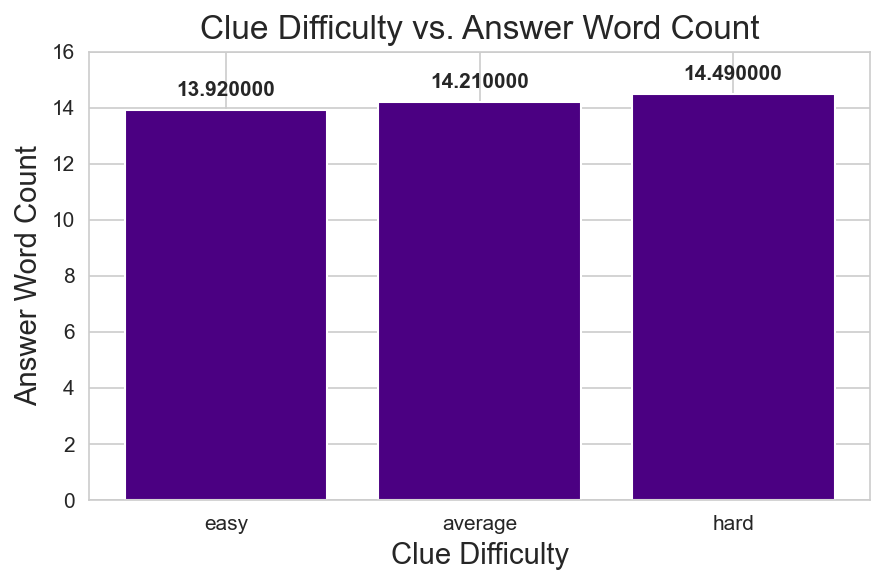

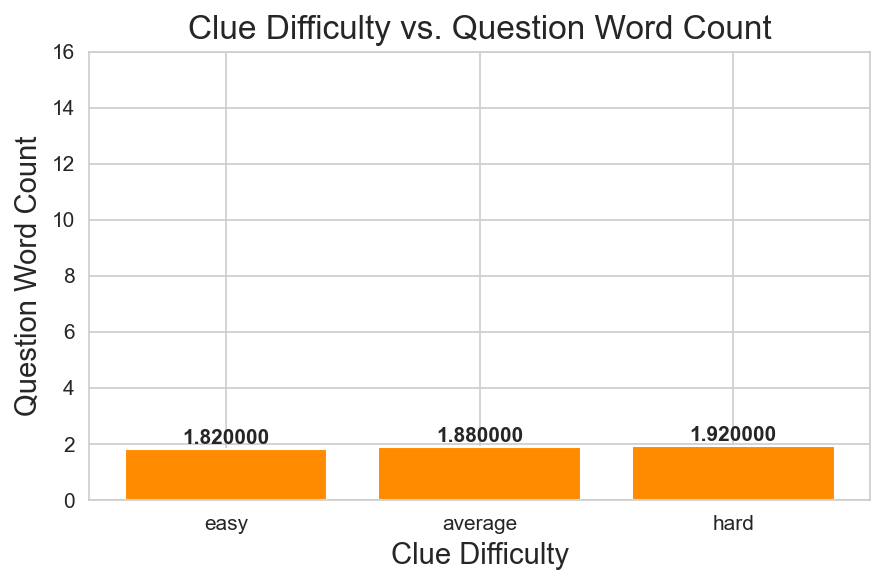

In [250]:
df = get_wrd_cts(special_tournaments)

avgs = df.groupby('Clue Difficulty').mean().sort_values('Answer Word Count').round(2)
maxes = df.groupby('Clue Difficulty').max().sort_values('Answer Word Count').round(2)

graph_wrd_cts(avgs, 'Answer Word Count', color = 'indigo')
graph_wrd_cts(avgs, 'Question Word Count', color = 'darkorange')

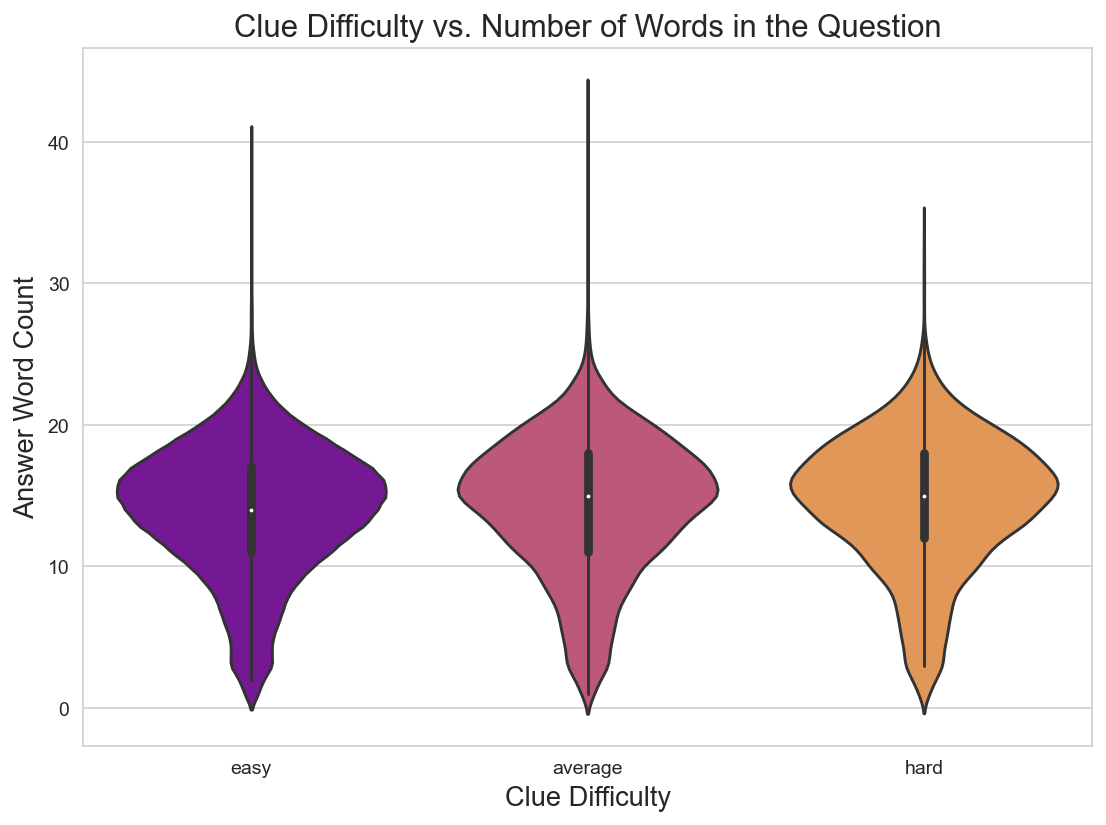

In [241]:
import seaborn as sns
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize = (8, 6), dpi = 140)
ax = sns.violinplot(x = 'Clue Difficulty', y = 'Answer Word Count', data = df, palette = 'plasma')
ax.set_ylabel('Answer Word Count', fontsize = 14)
ax.set_xlabel('Clue Difficulty', fontsize = 14)
ax.set_title("Clue Difficulty vs. Number of Words in the Question", fontsize = 16)
plt.tight_layout()
        
    

2


In [ ]:
jeopardy['notes'].str.contains('kids')

# Other Functions 

## Clean the text step-by-step
- remove punctuation
- remove stopwords
- lowercase 
- tokenize 
- lemmatize
## The function below aren't used

In [257]:
# Clean the text individually
def make_text(df, col):
    return df[col]

def lowercase(text):
    return ' '.join(text).lower()

def tokenize(text):
#     text = lowercase(df, col)
    tokenized = [word_tokenize(content) for content in text]
    return tokenized

#TODO: fix up this function 
def remove_punc(df, col):
    """
    removes punctuation from a column of text
    Args:
        df (Pandas dataFrame): The dataframe in use
        col (str): the column name to turn into a string
    Returns:
        [type]: [description]
    """        
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in ' '.join(tokenize(df, col))]
    return stripped

def remove_stopwords(text):
#     docs = tokenize(df, col)
#     text = lowercase(df, col)
    stopwords_set = set(stopwords.words('english'))
    return [[word for word in text if word not in stopwords_set] for word in text]

make_text(jeopardy, 'category')

pandas.core.series.Series

## clean_columns + wordclouds WITH stemming and lemmatizing

In [164]:
def clean_columns(df, col, stem = None):
    """
        cleans the columns by converting to a string, 
    lowercasing, removing stopwords, and tokenizing all in one 

    Args:
        df (pandas DataFrame): the DataFrame whose columns 
                will be turned to one string
        col (string): The column name in question
        stem (string), (optional):
                "snowball" for snowball stemmer
                "porter" for porter stemmer. 
                Defaults to None.

    Returns:
        list: a list of words as strings
    """
    text = stringify(df, col)
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # lemmatize the words 
    wordnet = WordNetLemmatizer()
    lemmatized = [wordnet.lemmatize(word) for word in stripped]
    
    #stem words, depending on the stemmer chosen as a parameter
    if stem == 'snowball':
        snowball = SnowballStemmer('english')
        stemmed = [snowball.stem(word) for word in lemmatized]
        # remove remaining tokens that are not alphabetic from stemmed
        words = [word for word in stemmed if word.isalpha()]
    elif stem == 'porter':
        porter = PorterStemmer()
        stemmed = [porter.stem(word) for word in lemmatized]
        # remove remaining tokens that are not alphabetic from stemmed
        words = [word for word in stemmed if word.isalpha()]
    elif stem == None:
        pass
        #skip stemming
        # remove remaining tokens that are not alphabetic from lemmatized
    else:
        words = [word for word in lemmatized if word.isalpha()]
    
    # filter out stop words
    if col == 'notes':
        #TODO: add another set of stopwords for the notes
        remove_words = {'final', 'quarterfinal', 'game', 'jeopardy!', 'semifinal', 'round', 'tournament', 'week', 'reunion', 'ultimate', 'night', 'jeopardy', 'night', 'games'}
        stopwords_set = (set(stopwords.words('english'))).union(remove_words)
    else:
        stopwords_set = set(stopwords.words('english'))
    words = [w for w in words if not w in stopwords_set]
    return words

In [165]:
def make_word_cloud(df, col, color, stem = None, save = False):
    """makes a word cloud of the words per column

    Args:
        df (pandas DataFrame): the DataFrame whose columns 
                will be turned to one string
        col (string): the string in question 
        color (string): the colormap preset to use
        save (bool, optional): Whether to save the figure or just show
                will save the figure as a .png, False will show the figure
                Defaults to False.
    """    
    #generate word list
    word_lst = clean_columns(df, col, stem = None) # can also get the words from the text vectorizer above
    words = ' '.join(word_lst)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color =None, mode = 'RGBA', 
                colormap = color,
                collocations=False,
                min_font_size = 10).generate(words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    if save:
        plt.savefig(f'../images/{col}_wordcloud.png')
    else:
        plt.show()
        
# make_word_cloud(jeopardy, 'category', stem = None, color = 'plasma', save = True)
# make_word_cloud(jeopardy, 'question', stem = None, color = 'Blues_r', save = True)
# make_word_cloud(jeopardy_subtrain, 'answer', stem = None, color = 'cividis_r', save = True)

## Wordcloud Colors

Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'